# Import

In [5]:
!pip install prettytable

In [3]:
import os
import json
from collections import OrderedDict, defaultdict

In [6]:
import numpy as np
import cv2
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import torch
from torch import nn

In [11]:
from mmseg.registry import DATASETS, TRANSFORMS, MODELS, METRICS
from mmseg.datasets import BaseSegDataset
from mmseg.models.segmentors import EncoderDecoder
from mmseg.models.decode_heads import ASPPHead, FCNHead, SegformerHead
from mmseg.models.utils.wrappers import resize


from mmengine.config import Config
from mmengine.dataset import Compose
from mmengine.runner import Runner, load_checkpoint
from mmengine.evaluator import BaseMetric
from mmengine.logging import MMLogger, print_log
from mmengine.structures import PixelData

from mmcv.transforms import BaseTransform

In [12]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/opt/ml/data/train/DCM/"
LABEL_ROOT = "/opt/ml/data/train/outputs_json/"

In [13]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [14]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [15]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [16]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [17]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# MixIn Classes

In [18]:
class PostProcessResultMixin:
    def postprocess_result(self,
                           seg_logits,
                           data_samples):
        """ Convert results list to `SegDataSample`.
        Args:
            seg_logits (Tensor): The segmentation results, seg_logits from
                model of each input image.
            data_samples (list[:obj:`SegDataSample`]): The seg data samples.
                It usually includes information such as `metainfo` and
                `gt_sem_seg`. Default to None.
        Returns:
            list[:obj:`SegDataSample`]: Segmentation results of the
            input images. Each SegDataSample usually contain:

            - ``pred_sem_seg``(PixelData): Prediction of semantic segmentation.
            - ``seg_logits``(PixelData): Predicted logits of semantic
                segmentation before normalization.
        """
        batch_size, C, H, W = seg_logits.shape

        if data_samples is None:
            data_samples = [SegDataSample() for _ in range(batch_size)]
            only_prediction = True
        else:
            only_prediction = False

        for i in range(batch_size):
            if not only_prediction:
                img_meta = data_samples[i].metainfo
                # remove padding area
                if 'img_padding_size' not in img_meta:
                    padding_size = img_meta.get('padding_size', [0] * 4)
                else:
                    padding_size = img_meta['img_padding_size']
                padding_left, padding_right, padding_top, padding_bottom =\
                    padding_size
                # i_seg_logits shape is 1, C, H, W after remove padding
                i_seg_logits = seg_logits[i:i + 1, :,
                                          padding_top:H - padding_bottom,
                                          padding_left:W - padding_right]

                flip = img_meta.get('flip', None)
                if flip:
                    flip_direction = img_meta.get('flip_direction', None)
                    assert flip_direction in ['horizontal', 'vertical']
                    if flip_direction == 'horizontal':
                        i_seg_logits = i_seg_logits.flip(dims=(3, ))
                    else:
                        i_seg_logits = i_seg_logits.flip(dims=(2, ))

                # resize as original shape
                i_seg_logits = resize(
                    i_seg_logits,
                    size=img_meta['ori_shape'],
                    mode='bilinear',
                    align_corners=self.align_corners,
                    warning=False).squeeze(0)
            else:
                i_seg_logits = seg_logits[i]

            i_seg_logits = i_seg_logits.sigmoid()
            i_seg_pred = (i_seg_logits > 0.5).to(i_seg_logits)
                
            data_samples[i].set_data({
                'seg_logits':
                PixelData(**{'data': i_seg_logits}),
                'pred_sem_seg':
                PixelData(**{'data': i_seg_pred})
            })

        return data_samples

In [19]:
@MODELS.register_module()
class EncoderDecoderWithoutArgmax(PostProcessResultMixin, EncoderDecoder):
    pass

KeyError: 'EncoderDecoderWithoutArgmax is already registered in model at mmseg.models.segmentors.encoder_decoder'

In [20]:
class LossByFeatMixIn:
    def loss_by_feat(self, seg_logits, batch_data_samples) -> dict:
        """Compute segmentation loss.

        Args:
            seg_logits (Tensor): The output from decode head forward function.
            batch_data_samples (List[:obj:`SegDataSample`]): The seg
                data samples. It usually includes information such
                as `metainfo` and `gt_sem_seg`.

        Returns:
            dict[str, Tensor]: a dictionary of loss components
        """

        seg_label = self._stack_batch_gt(batch_data_samples)
        loss = dict()
        seg_logits = resize(
            input=seg_logits,
            size=seg_label.shape[2:],
            mode='bilinear',
            align_corners=self.align_corners)
        if self.sampler is not None:
            seg_weight = self.sampler.sample(seg_logits, seg_label)
        else:
            seg_weight = None

        if not isinstance(self.loss_decode, nn.ModuleList):
            losses_decode = [self.loss_decode]
        else:
            losses_decode = self.loss_decode
        for loss_decode in losses_decode:
            if loss_decode.loss_name not in loss:
                loss[loss_decode.loss_name] = loss_decode(
                    seg_logits,
                    seg_label,
                    weight=seg_weight,
                    ignore_index=self.ignore_index)
            else:
                loss[loss_decode.loss_name] += loss_decode(
                    seg_logits,
                    seg_label,
                    weight=seg_weight,
                    ignore_index=self.ignore_index)

        return loss

In [21]:
# @MODELS.register_module()
# class ASPPHeadWithoutAccuracy(LossByFeatMixIn, ASPPHead):
#     pass

KeyError: 'ASPPHeadWithoutAccuracy is already registered in model at mmseg.models.decode_heads.aspp_head'

In [22]:
# @MODELS.register_module()
# class FCNHeadWithoutAccuracy(LossByFeatMixIn, FCNHead):
#     pass

KeyError: 'FCNHeadWithoutAccuracy is already registered in model at mmseg.models.decode_heads.fcn_head'

In [15]:
# @MODELS.register_module()
# class SegformerHeadWithoutAccuracy(LossByFeatMixIn, SegformerHead):
#     pass

# Dataset

In [23]:
@DATASETS.register_module()
class XRayDataset(BaseSegDataset):
    def __init__(self, is_train, **kwargs):
        self.is_train = is_train
        
        super().__init__(**kwargs)
        
    def load_data_list(self):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if self.is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        data_list = []
        for i, (img_path, ann_path) in enumerate(zip(filenames, labelnames)):
            data_info = dict(
                img_path=os.path.join(IMAGE_ROOT, img_path),
                seg_map_path=os.path.join(LABEL_ROOT, ann_path),
            )
            data_list.append(data_info)
        
        return data_list

In [24]:
@TRANSFORMS.register_module()
class LoadXRayAnnotations(BaseTransform):
    def transform(self, result):
        label_path = result["seg_map_path"]
        
        image_size = (2048, 2048)
        
        # process a label of shape (H, W, NC)
        label_shape = image_size + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # read label file
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # iterate each class
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon to mask
            class_label = np.zeros(image_size, dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        result["gt_seg_map"] = label
        
        return result

KeyError: 'LoadXRayAnnotations is already registered in transform at mmseg.datasets.transforms.LoadXRayAnnotations'

In [25]:
@TRANSFORMS.register_module()
class TransposeAnnotations(BaseTransform):
    def transform(self, result):
        result["gt_seg_map"] = np.transpose(result["gt_seg_map"], (2, 0, 1))
        
        return result

# Metric

In [26]:
@METRICS.register_module()
class DiceMetric(BaseMetric):
    def __init__(self,
                 collect_device='cpu',
                 prefix=None,
                 **kwargs):
        super().__init__(collect_device=collect_device, prefix=prefix)
        
    @staticmethod
    def dice_coef(y_true, y_pred):        
        y_true_f = y_true.flatten(-2)
        y_pred_f = y_pred.flatten(-2)
        intersection = torch.sum(y_true_f * y_pred_f, -1)

        eps = 0.0001
        return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

    def process(self, data_batch, data_samples):
        """Process one batch of data and data_samples.

        The processed results should be stored in ``self.results``, which will
        be used to compute the metrics when all batches have been processed.

        Args:
            data_batch (dict): A batch of data from the dataloader.
            data_samples (Sequence[dict]): A batch of outputs from the model.
        """
        for data_sample in data_samples:
            pred_label = data_sample['pred_sem_seg']['data']
            
            label = data_sample['gt_sem_seg']['data'].to(pred_label)
            self.results.append(
                self.dice_coef(label, pred_label)
            )

    def compute_metrics(self, results):
        """Compute the metrics from processed results.

        Args:
            results (list): The processed results of each batch.

        Returns:
            Dict[str, float]: The computed metrics. The keys are the names of
                the metrics, and the values are corresponding results.
        """
        logger: MMLogger = MMLogger.get_current_instance()
            
        results = torch.stack(self.results, 0)        
        dices_per_class = torch.mean(results, 0)
        avg_dice = torch.mean(dices_per_class)
            
        ret_metrics = {
            "Dice": dices_per_class.detach().cpu().numpy(),
        }
        # summary table
        ret_metrics_summary = OrderedDict({
            ret_metric: np.round(np.nanmean(ret_metric_value) * 100, 2)
            for ret_metric, ret_metric_value in ret_metrics.items()
        })
        
        metrics = {
            "mDice": torch.mean(dices_per_class).item()
        }

        # each class table
        ret_metrics.pop('aAcc', None)
        ret_metrics_class = OrderedDict({
            ret_metric: np.round(ret_metric_value * 100, 2)
            for ret_metric, ret_metric_value in ret_metrics.items()
        })
        ret_metrics_class.update({'Class': CLASSES})
        ret_metrics_class.move_to_end('Class', last=False)
        class_table_data = PrettyTable()
        for key, val in ret_metrics_class.items():
            class_table_data.add_column(key, val)

        print_log('per class results:', logger)
        print_log('\n' + class_table_data.get_string(), logger=logger)

        return metrics

# Configs

In [27]:
%%writefile dataset_setting.py

# dataset settings
dataset_type = 'XRayDataset'
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadXRayAnnotations'),
    dict(type='Resize', scale=(512, 512)),
    dict(type='TransposeAnnotations'),
    dict(type='PackSegInputs')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512)),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadXRayAnnotations'),
    dict(type='TransposeAnnotations'),
    dict(type='PackSegInputs')
]
train_dataloader = dict(
    batch_size=8,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='InfiniteSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        is_train=True,
        pipeline=train_pipeline
    )
)
val_dataloader = dict(
    batch_size=1,
    num_workers=0,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        is_train=False,
        pipeline=test_pipeline
    )
)
test_dataloader = val_dataloader

val_evaluator = dict(type='DiceMetric')
test_evaluator = val_evaluator

Writing dataset_setting.py


In [37]:
%%writefile config_for_this_example.py

# Train Segformer Mit B0
_base_ = [
    "mmsegmentation/configs/_base_/models/segformer_mit-b0.py",
    "dataset_setting.py",
    "mmsegmentation/configs/_base_/default_runtime.py"
]

data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[0., 0., 0.],
    std=[255., 255., 255.],
    bgr_to_rgb=True,
    size=(512, 512),
    pad_val=0,
    seg_pad_val=255,
)

model = dict(
    type='EncoderDecoderWithoutArgmax',
    init_cfg=dict(
        type='Pretrained',
        # load ADE20k pretrained EncoderDecoder from mmsegmentation
        checkpoint="https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b0_512x512_160k_ade20k/segformer_mit-b0_512x512_160k_ade20k_20210726_101530-8ffa8fda.pth"
    ),
    data_preprocessor=data_preprocessor,
    decode_head=dict(
        type='SegformerHeadWithoutAccuracy',
        num_classes=29,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=True,
            loss_weight=1.0,
        ),
    ),
)

# optimizer
optimizer = dict(type='AdamW', lr=0.00006, betas=(0.9, 0.999), weight_decay=0.01)
optim_wrapper = dict(type='OptimWrapper', optimizer=optimizer, clip_grad=None)
# learning policy
param_scheduler = [
    dict(
        type='LinearLR', start_factor=1e-6, by_epoch=False, begin=0, end=1500
    ),
    dict(
        type='PolyLR',
        eta_min=0.0,
        power=1.0,
        begin=1500,
        end=20000,
        by_epoch=False,
    )
]
# training schedule for 20k
train_cfg = dict(type='IterBasedTrainLoop', max_iters=20000, val_interval=2000)
val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')
default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=50, log_metric_by_epoch=False),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', by_epoch=False, interval=2000),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    visualization=dict(type='SegVisualizationHook')
)

Overwriting config_for_this_example.py


# Train

In [40]:
# load config
cfg = Config.fromfile("config_for_this_example.py")
cfg.launcher = "none"
cfg.work_dir = os.path.join('./work_dirs', "baseline")

# resume training
cfg.resume = False

runner = Runner.from_cfg(cfg)

# start training
runner.train()

FileNotFoundError: file "/opt/ml/input/level2_cv_semanticsegmentation-cv-12/mmsegmentation/configs/_base_/models/segformer_mit-b0.py" does not exist

# Result visualization

In [34]:
model = MODELS.build(cfg.model)

/workspace/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/workspace/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [37]:
checkpoint = load_checkpoint(
    model,
    "work_dirs/baseline/iter_20000.pth",
    map_location='cpu'
)

Loads checkpoint by local backend from path: work_dirs/baseline/iter_20000.pth


In [42]:
def _preprare_data(imgs, model):
    for t in cfg.test_pipeline:
        if t.get('type') in ['LoadXRayAnnotations', 'TransposeAnnotations']:
            cfg.test_pipeline.remove(t)

    is_batch = True
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
        is_batch = False

    if isinstance(imgs[0], np.ndarray):
        cfg.test_pipeline[0]['type'] = 'LoadImageFromNDArray'

    # TODO: Consider using the singleton pattern to avoid building
    # a pipeline for each inference
    pipeline = Compose(cfg.test_pipeline)

    data = defaultdict(list)
    for img in imgs:
        if isinstance(img, np.ndarray):
            data_ = dict(img=img)
        else:
            data_ = dict(img_path=img)
        data_ = pipeline(data_)
        data['inputs'].append(data_['inputs'])
        data['data_samples'].append(data_['data_samples'])

    return data, is_batch

In [49]:
# define colors
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# utility function
# this does not care overlap
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [40]:
img = cv2.imread(os.path.join(IMAGE_ROOT, "ID001", "image1661130828152_R.png"))

In [47]:
# prepare data
data, is_batch = _preprare_data(img, model)

# forward the model
with torch.no_grad():
    results = model.test_step(data)

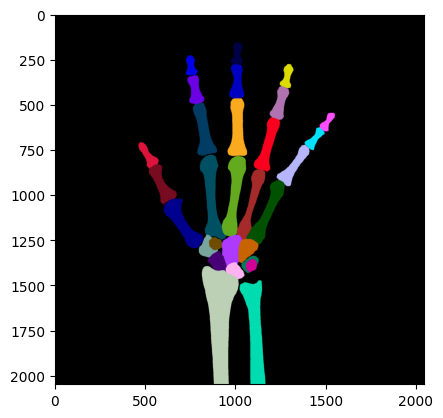

In [57]:
plt.imshow(label2rgb(results[0].pred_sem_seg.data))